# Artificial Neural Network for chest X-ray image distinction

### Training model for production with all images

Model was trained to distinguish 3 classes: (A) x-ray of the chest, (B) x-ray of other parts of the body and (C) any images
- Convolutional Neural network
- Transferlearning: VGG16 from the kernel 28
- batch_size = 10
- image shape = 299, 299
- epoch = 30

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import KFold
import datetime
from ilan import multiclass_metrics
import matplotlib.pyplot as plt
from IPython.display import Markdown

In [2]:
display(Markdown('#### Dataset description'))
qtd_modelo = {  'Training': [9377 , 20010 ,19995]}
df_qtd_modelo = pd.DataFrame(data=qtd_modelo,  index=['X-ray', 'No X-ray', 'Chest X-ray'], dtype=int)
df_qtd_modelo.loc['Total'] = df_qtd_modelo.sum(axis=0)
df_qtd_modelo['% Training'] = ['%.1f'%(df_qtd_modelo.loc['X-ray','Training']/df_qtd_modelo.loc['Total','Training']*100),
                                      '%.1f'%(df_qtd_modelo.loc['No X-ray','Training']/df_qtd_modelo.loc['Total','Training']*100),
                              '%.1f'%(df_qtd_modelo.loc['Chest X-ray','Training']/df_qtd_modelo.loc['Total','Training']*100),
                              '%.1f'%(df_qtd_modelo.loc['Total','Training']/df_qtd_modelo.loc['Total','Training']*100)]
df_qtd_modelo

#### Dataset description

,Training,% Training
X-ray,9377,19.0
No X-ray,20010,40.5
Chest X-ray,19995,40.5
Total,49382,100.0


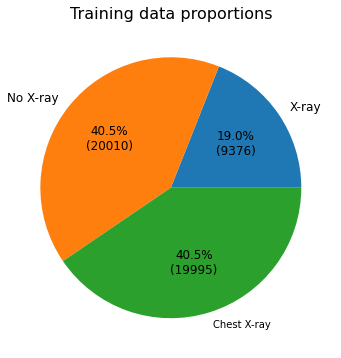

In [7]:

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

sum_chest_tc = df_qtd_modelo['Training']['X-ray']
sum_others_tc = df_qtd_modelo['Training']['No X-ray']
sum_no_tc = df_qtd_modelo['Training']['Chest X-ray']

recipe = [str(sum_chest_tc), str(sum_others_tc), str(sum_no_tc)]
data = [float(x.split()[0]) for x in recipe]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, labels=['X-ray','No X-ray','Chest X-ray'], autopct=lambda pct: func(pct, data), textprops=dict(color="k"))
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)

plt.setp(autotexts, size=12)
# plt.legend(labels=group_names,loc="best")
ax.set_title("Training data proportions", size=16)
plt.show()

### Import VGG16 pre-trained model

In [3]:
img_width, img_height = 299, 299 
batch_size = 10

vgg16 = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
display(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

None

### Freezing layers of VGG16 before the kernel 28

In [4]:
for layer in vgg16.layers[:-8]: layer.trainable = False

for layer in vgg16.layers: print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb1c4496e90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb08516d110> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb085003450> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb084b01bd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb084217a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb08571e650> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb08422d790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb084b018d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb084240d10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb084245d10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb08424bfd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [5]:
display(Markdown('### Dataframe for flow_from_directory'))
dataframe = pd.read_csv('dataframe.csv')
dataframe

### Dataframe for flow_from_directory

,id,label
0,/scratch/v_project/diagnosticos/pre_processing...,xray
1,/scratch/v_project/diagnosticos/pre_processing...,xray
2,/scratch/v_project/diagnosticos/pre_processing...,xray
3,/scratch/v_project/diagnosticos/pre_processing...,xray
4,/scratch/v_project/diagnosticos/pre_processing...,xray
...,...,...
49377,/scratch/v_project/diagnosticos/pre_processing...,no_xray
49378,/scratch/v_project/diagnosticos/pre_processing...,no_xray
49379,/scratch/v_project/diagnosticos/pre_processing...,no_xray
49380,/scratch/v_project/diagnosticos/pre_processing...,no_xray


In [ ]:
# with tf.device('/gpu:3'): #gpu 0 estava ocupada
epochs = 30 

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=dataframe,
directory="./train/",
x_col="id",
y_col="label",
subset="training",
batch_size=batch_size,
shuffle=False,
class_mode="categorical",
target_size=(img_width, img_height))

num_classes = len(train_generator.class_indices) 
print('Quantidade de classes:',num_classes)
# get the class labels for the training data, in the original order 
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

In [ ]:
model_name = 'valid_cxr_model'

#create the model
model = Sequential()
#Add the vgg convolutional base model
model.add(vgg16)
#ADd new layers
model.add(Flatten()) 
model.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
#     model.add(Dropout(0.5)) 
model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
#     model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

display(model.summary())

print('Parametros do backlog')
csv_log = CSVLogger(model_name + '.log')

filepath=(model_name + '_{epoch:02d}_AC{acc:.3f}_L{loss:.5f}.h5') 

callbacks_list = [ModelCheckpoint(filepath,
                                  monitor='acc',
                                  include_optimizer=False,
                                  save_best_only=True),
                  EarlyStopping(monitor='acc', patience=20, restore_best_weights=True), csv_log]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=1)

In [ ]:
#save model
model.save(model_name + '.h5')
print('Final model h5 saved')
# model.save_weights('weights'+top_model_weights_path)

start = datetime.datetime.now()
(train_loss, train_accuracy) = model.evaluate( 
    train_generator,use_multiprocessing=True)
print('[INFO] accuracy: {:.2f}%'.format(train_accuracy * 100)) 
print('[INFO] Loss: {}'.format(train_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time spent evaluating:', elapsed)

#Graphing our training
plt.figure(figsize=(14,4))
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)




In [ ]:
# model = load_model(model_name + '.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})

In [ ]:
start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)

In [ ]:
save_path = './out/%s' %model_name

classes = ['Chest x-ray','No x-ray','X-ray']
metricas = multiclass_metrics.get_metrics(train_labels, preds, columns=classes,save_path=save_path)
# df_metricas = pd.concat([df_metricas,metricas])
# df_metricas.to_csv('wholedataset_8layers_metrics',index=False)
display(metricas)

multiclass_metrics.plot_graphics(train_labels,preds, class_names=classes,save_path=save_path)

# print('Métricas')
# display(metricas)